
# 03_FuzzyTravelPlanner.ipynb

**Course:** Fuzzy Sets & Systems — Swiss Joint Master of Science in Computer Science  
**Notebook Type:** Fuzzy **Control System** (rule-based) using `scikit-fuzzy`  
**Author:** Alba Adili

This notebook implements a **Fuzzy Travel Planner** that recommends a destination suitability score based on three inputs:
- **Weather** (cold, mild, hot)  
- **Budget** (low, medium, high)  
- **Safety** (unsafe, moderate, safe)

It follows the structure of the scikit-fuzzy **Fuzzy Control Primer** (the same style as the classic Tipping example).  
Reference: https://scikit-fuzzy.github.io/scikit-fuzzy/userguide/fuzzy_control_primer.html



## Objectives
1. Define fuzzy **antecedents** (inputs) and **consequent** (output).  
2. Specify **membership functions** for each linguistic term.  
3. Create **IF–THEN** fuzzy rules.  
4. Build and simulate a fuzzy **Control System**.  
5. Visualize membership functions, inference, and a **3D response surface**.  
6. Provide guidance for adaptation and extensions.



## 1) Setup



In [3]:

import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("scikit-fuzzy:", fuzz.__version__)


NumPy: 2.1.3
Matplotlib: 3.10.0
scikit-fuzzy: 0.5.0



## 2) Define universes and linguistic variables

We define the input (antecedent) and output (consequent) variables and their universes.

- **weather**: 0→10 (0=coldest, 10=hot) — terms: *cold, mild, hot*  
- **budget**: 0→10 (0=low, 10=high) — terms: *low, medium, high*  
- **safety**: 0→10 (0=unsafe, 10=very safe) — terms: *unsafe, moderate, safe*  
- **suitability**: 0→100 (0=not suitable, 100=very suitable) — terms: *poor, fair, excellent*


In [4]:

# Antecedents (inputs)
weather = ctrl.Antecedent(np.arange(0, 11, 1), 'weather')
budget  = ctrl.Antecedent(np.arange(0, 11, 1), 'budget')
safety  = ctrl.Antecedent(np.arange(0, 11, 1), 'safety')

# Consequent (output)
suitability = ctrl.Consequent(np.arange(0, 101, 1), 'suitability')

# Membership functions (triangular; simple and interpretable)
# Weather
weather['cold'] = fuzz.trimf(weather.universe, [0, 0, 5])
weather['mild'] = fuzz.trimf(weather.universe, [3, 5, 7])
weather['hot']  = fuzz.trimf(weather.universe, [6, 10, 10])

# Budget
budget['low']    = fuzz.trimf(budget.universe, [0, 0, 5])
budget['medium'] = fuzz.trimf(budget.universe, [3, 5, 7])
budget['high']   = fuzz.trimf(budget.universe, [6, 10, 10])

# Safety
safety['unsafe']   = fuzz.trimf(safety.universe, [0, 0, 4])
safety['moderate'] = fuzz.trimf(safety.universe, [3, 5, 7])
safety['safe']     = fuzz.trimf(safety.universe, [6, 10, 10])

# Suitability
suitability['poor']      = fuzz.trimf(suitability.universe, [0, 0, 50])
suitability['fair']      = fuzz.trimf(suitability.universe, [25, 50, 75])
suitability['excellent'] = fuzz.trimf(suitability.universe, [50, 100, 100])



### Visualize membership functions
The plots below show how crisp values map to fuzzy terms. This helps validate the design.


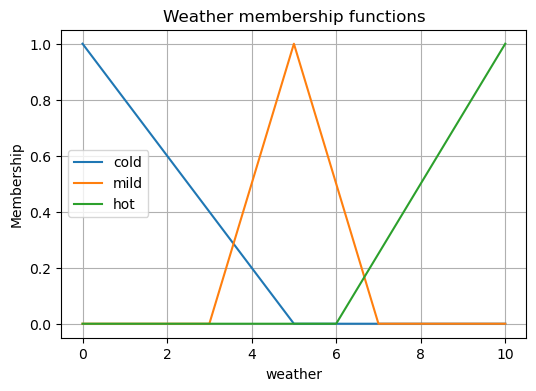

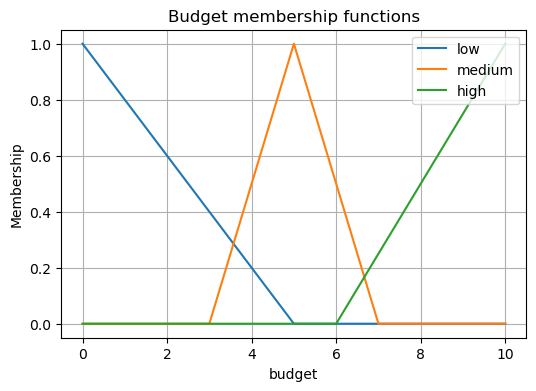

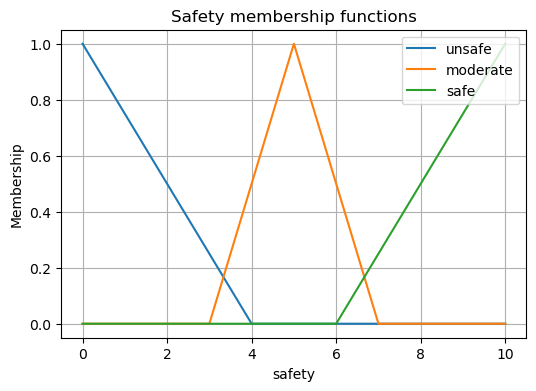

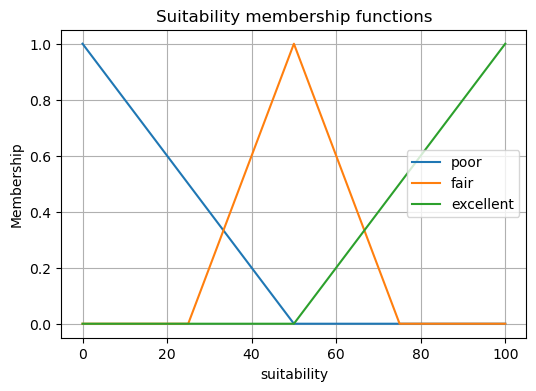

In [5]:

def plot_mfs(var, title):
    plt.figure(figsize=(6, 4))
    for term_name, term in var.terms.items():
        plt.plot(var.universe, term.mf, label=term_name)
    plt.title(title)
    plt.xlabel(var.label)
    plt.ylabel('Membership')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_mfs(weather,  'Weather membership functions')
plot_mfs(budget,   'Budget membership functions')
plot_mfs(safety,   'Safety membership functions')
plot_mfs(suitability, 'Suitability membership functions')


The membership functions define how crisp values are mapped to fuzzy sets.  
For example, a weather value of 7 belongs partly to "mild" and "hot".



## 3) Fuzzy rule base

I encoded interpretable **IF–THEN** rules.

**Rules** (examples):
1. IF (`weather` is **mild**) AND (`budget` is **high**) AND (`safety` is **safe**) THEN `suitability` is **excellent**.  
2. IF (`weather` is **cold**) AND (`budget` is **low**) THEN `suitability` is **poor**.  
3. IF (`weather` is **hot**) AND (`budget` is **medium**) AND (`safety` is **moderate**) THEN `suitability` is **fair**.  
4. IF (`weather` is **mild**) AND (`safety` is **unsafe**) THEN `suitability` is **poor**.  
5. IF (`weather` is **hot**) AND (`safety` is **safe**) THEN `suitability` is **fair**.


In [6]:

rule1 = ctrl.Rule(weather['mild'] & budget['high'] & safety['safe'], suitability['excellent'])
rule2 = ctrl.Rule(weather['cold'] & budget['low'], suitability['poor'])
rule3 = ctrl.Rule(weather['hot'] & budget['medium'] & safety['moderate'], suitability['fair'])
rule4 = ctrl.Rule(weather['mild'] & safety['unsafe'], suitability['poor'])
rule5 = ctrl.Rule(weather['hot'] & safety['safe'], suitability['fair'])

travel_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
travel_sim  = ctrl.ControlSystemSimulation(travel_ctrl)


The rules describe how weather, budget, and safety interact to produce a travel suitability score.



## 4) Single inference example

Provide crisp inputs and compute the **defuzzified** output.  


Recommended suitability: 50.00 / 100


/opt/anaconda3/lib/python3.13/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


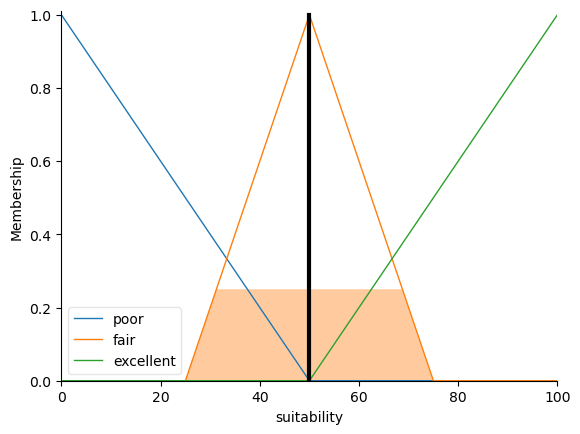

In [7]:

# Example crisp inputs
travel_sim.input['weather'] = 7   # fairly hot / mild-hot
travel_sim.input['budget']  = 8   # high
travel_sim.input['safety']  = 9   # safe

# Compute inference
travel_sim.compute()
result = travel_sim.output['suitability']
print(f"Recommended suitability: {result:.2f} / 100")

# Visualize activation on the output
suitability.view(sim=travel_sim)
plt.show()


For the inputs (weather=7, budget=8, safety=9), the fuzzy system computes a suitability of about 50/100, meaning the travel conditions are moderate.
This suggests that although the budget and safety are high, the weather (value=7) only partially activates the “excellent” region.


## 5) Sensitivity analysis (3D response surface)

I sweep **weather** and **budget** while keeping **safety** fixed, and visualize how the output changes.


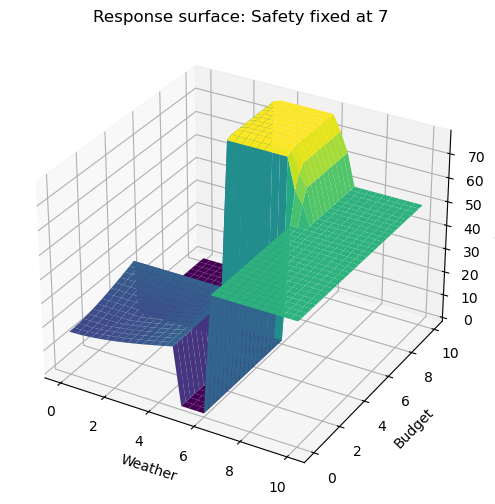

In [8]:
from mpl_toolkits.mplot3d import Axes3D  

w_vals = np.linspace(weather.universe.min(), weather.universe.max(), 31)
b_vals = np.linspace(budget.universe.min(),  budget.universe.max(),  31)

W, B = np.meshgrid(w_vals, b_vals)
Z = np.zeros_like(W, dtype=float)

# We'll use a fresh simulation per grid point to avoid state carryover.
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        sim = ctrl.ControlSystemSimulation(travel_ctrl)
        sim.input['weather'] = W[i, j]
        sim.input['budget']  = B[i, j]
        sim.input['safety']  = 7  
        
        try:
            sim.compute()
            Z[i, j] = sim.output['suitability']
        except KeyError:
            Z[i, j] = np.nan  # No valid rule fired

Z = np.nan_to_num(Z, nan=0.0)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(W, B, Z, cmap='viridis', linewidth=0, antialiased=True)
ax.set_xlabel('Weather')
ax.set_ylabel('Budget')
ax.set_zlabel('Suitability')
ax.set_title('Response surface: Safety fixed at 7')
plt.show()


The 3D response surface shows that higher budget and milder weather generally lead to higher travel suitability.



## 6) How to adapt / extend

- **Change universes**:  use 0→1 scales or different ranges for inputs.  
- **Membership shapes**: try trapezoids (`fuzz.trapmf`) or Gaussians (`fuzz.gaussmf`) for smoother transitions.  
- **More rules**: add 2–4 more rules to capture nuanced behaviors (*low budget but very safe & mild weather ⇒ fair*).  
- **More inputs**: add `distance` or `comfort` as a 4th antecedent.  
- **Interactive UI**: with `ipywidgets` sliders, create a small panel for live input tweaking.


In the future, I would like to extend this model by including new inputs such as *distance* or *comfort*, which could make the travel recommendation more realistic.



### Appendix: Quick experiment function
Multiple input scenarios.


In [10]:

def evaluate_suitability(w, b, s):
    sim = ctrl.ControlSystemSimulation(travel_ctrl)
    sim.input['weather'] = float(w)
    sim.input['budget']  = float(b)
    sim.input['safety']  = float(s)
    sim.compute()
    return sim.output['suitability']

# Example batch test
examples = [(3, 3, 3), (5, 7, 9), (9, 4, 8), (7, 8, 9)]
for w, b, s in examples:
    print(f"weather={w}, budget={b}, safety={s} -> suitability={evaluate_suitability(w,b,s):.2f}")


weather=3, budget=3, safety=3 -> suitability=20.42
weather=5, budget=7, safety=9 -> suitability=77.98
weather=9, budget=4, safety=8 -> suitability=50.00
weather=7, budget=8, safety=9 -> suitability=50.00


## Findings & Discussion
- The fuzzy control system works as expected and produces meaningful travel suitability scores.
- The model shows that high budget and safe destinations increase the travel suitability.
- The fuzzy approach is interpretable and flexible — it can be extended by adding more rules or inputs such as distance or comfort.
